In [1]:
from pennylane import numpy as np
import sys
sys.path.insert(0, '/home/tak/Github/QEmbedding/')
import torch
from torch import nn
import data
import pennylane as qml
import embedding

In [2]:
dev = qml.device('default.qubit', wires=8)

In [ ]:

PATH_Model2 = '/home/tak/Github/QEmbedding/Other Experiments/Scalability/8 qubits/PCA-NQE500.pt'
PATH_Model3 = '/home/tak/Github/QEmbedding/Other Experiments/Scalability/8 qubits/NQE500.pt'

In [ ]:
class x_transform2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(8, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, 16)
        )
        
    def forward(self, x):
        x = self.linear_relu_stack2(x)
        return x.detach().numpy()


class x_transform3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 16, bias=True)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        return x.detach().numpy()

model2 = x_transform2()
model3 = x_transform3()

model2.load_state_dict(torch.load(PATH_Model2))
model3.load_state_dict(torch.load(PATH_Model3))

In [ ]:
@qml.qnode(dev)
def overlap_circuit1(x1,x2):
    embedding.QuantumEmbedding1(x1)
    embedding.QuantumEmbedding1_inverse(x2)
    return qml.probs(wires=range(8))

@qml.qnode(dev)
def overlap_circuit2(x1,x2):
    embedding.QuantumEmbedding2(x1)
    embedding.QuantumEmbedding2_inverse(x2)
    return qml.probs(wires=range(8))

def kernel(x1, x2, NQE):
    if NQE == False:
        kernel = overlap_circuit1(x1,x2)
    
    
    elif NQE == 'PCA-NQE':
        x1 = model2(torch.tensor(x1))
        x2 = model2(torch.tensor(x2))
        kernel = overlap_circuit2(x1, x2)

    elif NQE == 'NQE':
        x1 = model3(torch.tensor(x1))[0]
        x2 = model3(torch.tensor(x2))[0]
        kernel = overlap_circuit2(x1,x2)
    
    return kernel

  

QKM without NQE

In [ ]:
feature_reduction = 'PCA8'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 3
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel0 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], False)
        Kernel0[i][j] = x[0]
        Kernel0[j][i] = x[0]

In [ ]:
Kernel_rank = np.linalg.matrix_rank(Kernel0)
Kernel_offD = []
for i in range(N):
    for j in range(i + 1, N):
        Kernel_offD.append(Kernel0[i][j])

Kernel_offD = np.array(Kernel_offD)
Kernel_element_variance = Kernel_offD.std()**2

f = open("Kernel Rank & Variance.txt", 'a')
f.write("\n")
f.write(f"Kernel0 iter {k}\n")
f.write(f"Kernel Rank: {Kernel_rank}\n")
f.write(f"Kernel Variance: {Kernel_element_variance}\n")
f.close()

QKM with PCA-NQE

In [ ]:
feature_reduction = 'PCA8'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 3
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel2 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], "PCA-NQE")
        Kernel2[i][j] = x[0]
        Kernel2[j][i] = x[0]

In [ ]:
Kernel_rank = np.linalg.matrix_rank(Kernel2)
Kernel_offD = []
for i in range(N):
    for j in range(i + 1, N):
        Kernel_offD.append(Kernel2[i][j])

Kernel_offD = np.array(Kernel_offD)
Kernel_element_variance = Kernel_offD.std()**2

f = open("Kernel Rank & Variance.txt", 'a')
f.write("\n")
f.write(f"Kernel2 iter {k}\n")
f.write(f"Kernel Rank: {Kernel_rank}\n")
f.write(f"Kernel Variance: {Kernel_element_variance}\n")
f.close()

QKM with NQE

In [ ]:
classes = [0,1]
feature_reduction = False
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0,3,1,2).detach().numpy(), X_test.permute(0,3,1,2).detach().numpy()
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 3
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel3 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], "NQE")
        Kernel3[i][j] = x[0]
        Kernel3[j][i] = x[0]

In [ ]:
Kernel_rank = np.linalg.matrix_rank(Kernel3)
Kernel_offD = []
for i in range(N):
    for j in range(i + 1, N):
        Kernel_offD.append(Kernel3[i][j])

Kernel_offD = np.array(Kernel_offD)
Kernel_element_variance = Kernel_offD.std()**2

f = open("Kernel Rank & Variance.txt", 'a')
f.write("\n")
f.write(f"Kernel2 iter {k}\n")
f.write(f"Kernel Rank: {Kernel_rank}\n")
f.write(f"Kernel Variance: {Kernel_element_variance}\n")
f.close()

## Expressibility

In [3]:
def random_unitary(n):
    """
        Return a Haar distributed random unitary from U(N)
    """

    Z = np.random.randn(2**n, 2**n) + 1.0j * np.random.randn(2**n, 2**n)
    [Q, R] = np.linalg.qr(Z)
    D = np.diag(np.diagonal(R) / np.abs(np.diagonal(R)))
    return np.dot(Q, D)

def haar_integral(num_qubits, samples):
    """
        Return calculation of Haar Integral for a specified number of samples.
    """

    n = num_qubits
    randunit_density = np.zeros((2**n, 2**n), dtype=complex)

    
    zero_state = np.zeros(2**n, dtype=complex)
    zero_state[0] = 1
    for _ in range(samples):
        U = random_unitary(n)
        A = np.matmul(zero_state, U).reshape(-1,1)
        randunit_density += np.kron(A, A.conj().T) 
    randunit_density/=samples

    return randunit_density

In [4]:


@qml.qnode(dev, interface="torch")
def circuit2(inputs): 
    embedding.QuantumEmbedding2(inputs)
    return qml.density_matrix(wires=range(8))

@qml.qnode(dev, interface="torch")
def circuit1(inputs): 
    embedding.QuantumEmbedding1(inputs)
    return qml.density_matrix(wires=range(8))


class exp0(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer0 = qml.qnn.TorchLayer(circuit1, weight_shapes={})

    def forward(self, x):
        rhos = self.qlayer0(x)
        rho = torch.sum(rhos, dim=0) / len(x)
        rho = rho.detach().numpy()
        exp = np.linalg.norm(rho - haar_integral(8, len(x)))
        return exp**2
    
    
class exp2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(circuit2, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(8, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, 16)
        )
    def forward(self, x):
        x = self.linear_relu_stack2(x)
        rhos = self.qlayer2(x)
        rho = torch.sum(rhos, dim=0) / len(x)
        rho = rho.detach().numpy()
        exp = np.linalg.norm(rho - haar_integral(8, len(x)))
        return exp**2


class exp3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3 = qml.qnn.TorchLayer(circuit2, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 16, bias=True)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        rhos = self.qlayer3(x)
        rho = torch.sum(rhos, dim=0) / len(x)
        rho = rho.detach().numpy()
        exp = np.linalg.norm(rho - haar_integral(8, len(x)))
        return exp**2

In [5]:
feature_reduction = 'PCA8'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
X_test =  torch.tensor(X_test).to(torch.float32)
X_train = torch.tensor(X_train).to(torch.float32)

/tmp/ipykernel_241720/466488815.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_test =  torch.tensor(X_test).to(torch.float32)


In [6]:
model0 = exp0()
model2 = exp2()
model2.load_state_dict(torch.load("PCA-NQE500.pt"))
exp_model0_train = model0(X_train[:100])
exp_model0_test = model0(X_test[:50])
print(f"Without NQE Expressibility Train Data: {exp_model0_train}")
print(f"Without NQE Expressibility Test Data: {exp_model0_test}")
exp_model2_train = model2(X_train[:100])
exp_model2_test = model2(X_test[:50])
print(f"PCA-NQE Expressibility Train Data: {exp_model2_train}")
print(f"PCA-NQE Expressibility Test Data: {exp_model2_test}")

/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/qnn/torch.py:331: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  return res.type(x.dtype)


Without NQE Expressibility Train Data: 0.024500393218770886
Without NQE Expressibility Test Data: 0.04039654890148732
PCA-NQE Expressibility Train Data: 0.2765968358930239
PCA-NQE Expressibility Test Data: 0.2850611775113244


In [10]:
feature_reduction = False
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)

In [11]:
model3 = exp3()
model3.load_state_dict(torch.load("NQE500.pt"))
exp_model3_train = model3(X_train[:100])
exp_model3_test = model3(X_test[:50])
print(f"PCA-NQE Expressibility Train Data: {exp_model3_train}")
print(f"PCA-NQE Expressibility Test Data: {exp_model3_test}")

PCA-NQE Expressibility Train Data: 0.2574753364868828
PCA-NQE Expressibility Test Data: 0.2866436262194087


In [2]:
Kernel0_variance = [0.0009153918274221285, 0.0006958928712654695, 0.0007072757303437999, 0.0006785826869208034, 0.0006301272771971951]
Kernel2_variance = [0.1856808242989811, 0.18107375304888448,  0.17895462488893604, 0.18077810468385555,  0.18135337383891176]
Kernel3_variance = [0.14617144190793305, 0.14014941969288583, 0.1396640703467334, 0.1364337669504927, 0.1401344370625499]

Kernel0_variance = np.array(Kernel0_variance)
Kernel2_variance = np.array(Kernel2_variance)
Kernel3_variance = np.array(Kernel3_variance)

exp0_train = 0.024500393218770886
exp0_test = 0.04039654890148732
exp2_train = 0.2765968358930239
exp2_test = 0.2850611775113244
exp3_train = 0.2574753364868828
exp3_test = 0.2866436262194087


print(np.sqrt(exp0_train), np.sqrt(exp0_test), np.sqrt(exp2_train), np.sqrt(exp2_test), np.sqrt(exp3_train), np.sqrt(exp3_test), )

0.15652601451123352 0.2009889273106539 0.5259247435641566 0.5339112075161229 0.5074202759910987 0.5353910965074118


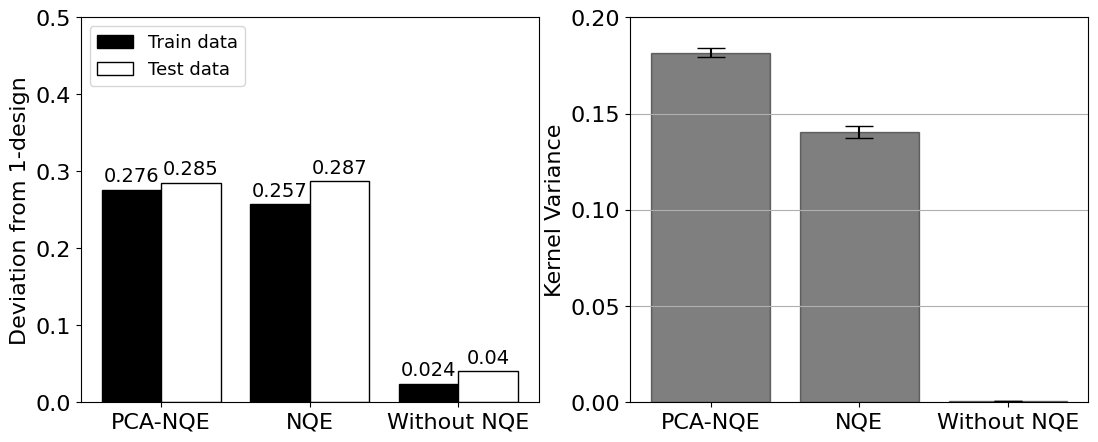

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 5]
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2) = plt.subplots(1,2)
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):
    X = ("PCA-NQE", "NQE", "Without NQE",)
    expressibility = {
        'Train data': (0.276, 0.257, 0.024),
        'Test data': (0.285, 0.287, 0.040),
    }
    Kernel_Variance = {
        'Kernel_Variance': (Kernel0_variance.mean(), Kernel2_variance.mean(), 
                            Kernel3_variance.mean())
    }

x = np.arange(len(X))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0


for attribute, measurement in expressibility.items():
    if attribute == 'Train data':
        color = "black"
    else:
        color = "white"
    offset = width * multiplier
    rects = ax1.bar(x + offset, measurement, width, label=attribute, color=color, edgecolor='black')
    ax1.bar_label(rects, padding=3, fontsize=14)
    multiplier += 1

#x = np.arange(len(X))  # the label locations
#width = 0.25 # the width of the bars
#multiplier = 0

#for attribute, measurement in Kernel_Variance.items():
#    if attribute == 'Kernel_Variance':
#        color = "white"
#    else:
#        color = "white"
#    offset = width * multiplier
#    rects = ax2.bar(x + offset, measurement, width, label=attribute, color=color, edgecolor='black')
#    ax2.bar_label(rects,padding=3, fontsize=10)
#    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Deviation from 1-design')
#ax1.set_title('Expressibility')
ax1.set_xticks(x + width - 0.2, X)
ax1.legend(loc='upper left', ncols=1, fontsize=13)
ax1.set_ylim(0, 0.5)

x_pos = np.arange(3)
y = [Kernel2_variance.mean(), Kernel3_variance.mean(), Kernel0_variance.mean()]
error = [Kernel2_variance.std(), Kernel3_variance.std(), Kernel0_variance.std()]
ax2.bar(x_pos, y, yerr=error, align='center', alpha=0.5, color='black', edgecolor='black',ecolor='black', capsize=10)
ax2.set_ylabel('Kernel Variance')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(X)
#ax2.set_title('Kernel Variance')
ax2.set_yticks([0,0.05,0.1,0.15, 0.2])
ax2.yaxis.grid(True)
#ax2.set_ylabel('Kernel Variance')
#ax2.set_title('Kernel Variance')
#ax2.set_xticks(x + width - 0.25, X)
#ax2.set_ylim(0, 0.5)

plt.savefig("Expressibility.pdf")
plt.show()
